# Assignment 2

Note: this notebook takes approximately 5 minutes to run.

## Task 1

### Review Ingestion

pandas is used to read the car reviews CSV and dataframes are used extensively throughout for data manipulation.

In [1]:
"""
Define all notebook inputs and base ingestion behaviour.
"""

# NLTK imports and downloads
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Standard library imports
import warnings
import unicodedata
from abc import ABC
from collections import Counter

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer as wnl

# Ignore unneeded token_pattern warnings to improve notebook readability
warnings.filterwarnings(
    "ignore", 
    message="The parameter 'token_pattern' will not be used since 'tokenizer' is not None"
)

# Render pandas dataframes without max row/column constraints
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Render numpy arrays without max row/column constraints
np.set_printoptions(threshold=np.inf)

class Ingestor(ABC):
    """
    Base ingestor class defining core data ingestion functionality.
    Uses stemming, stop word and special character filtering, accent stripping and tokenisation
    """
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
        self.stop_words = set(stopwords.words('english'))
    
    def ingest_reviews(self, filename = "car-reviews.csv"):
        return pd.read_csv(filename)

    def tokenize_and_stem(self, text):
        # Remove accents
        stripped_text = self.strip_accents(text)
        
        # Tokenize text
        tokens = word_tokenize(stripped_text)
        
        # Include only alphanumeric tokens and convert tokens to lowercase
        tokens = [token.lower() for token in tokens if token.isalnum()]
        
        # Remove stop words found in NLTK's stop word corpus
        filtered_tokens = [word for word in tokens if word not in self.stop_words]
        
        # Stem tokens using NLTK's SnowballStemmer class
        return [self.stemmer.stem(token) for token in filtered_tokens]
    
    # Using scikit-learn's train_test_split to arrange the data into an 80/20 split.
    # Using random_state=1 to ensure consistent splitting selection
    # Only first tuple return element is used for training (80%), second element for testing (20%)
    def split_reviews(self, df, test_size = 0.2):
        return train_test_split(df, test_size = test_size, random_state = 1, stratify=df['Sentiment'])
    
    def strip_accents(self, text):
        # Normalize the text by splitting combined characters into their base characters and separate 
        # accent components
        text = unicodedata.normalize('NFD', text)
        
        # Reconstruct the string by filtering out all non-spacing marks. These non-spacing marks are the 
        # accent components, so removing them strips accents from the original text.
        return ''.join(char for char in text if unicodedata.category(char) != 'Mn')
    
ingestor = Ingestor()
df = ingestor.ingest_reviews()

# Internally train_test_split rounds up, so need to set a fixed integer size to get 276 test examples as 
# specified in the question
test_size_int = int(len(df) * 0.2)
train_df, test_df = ingestor.split_reviews(df, test_size = test_size_int)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jwestgomila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jwestgomila/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jwestgomila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jwestgomila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Data Splitting Demonstration

scikit-learn's train_test_split is used internally to split the data into training and test sets. Of note, random_state is set to 1 to ensure reproducible split distributions across multiple runs.

stratify is set to the "Sentiment" column values to ensure a balanced distribution of positive and negative reviews across both the training and test sets. Stratification of the data set ensures the training and test sets reflect the true distribution of classes, and a balanced representation allows the model to learn from both classes, reducing the risk of bias towards one or the other.

In [2]:
"""
Demonstrate train/test split behaviour.
"""

print(Counter(df['Sentiment']))
print(Counter(train_df['Sentiment']))
print(Counter(test_df['Sentiment']))
print()

print(f"Training set % of original data set {len(train_df) / len(df)}, with {len(train_df)} examples")
print(f"Test set % of original data set: {len(test_df) / len(df)}, with {len(test_df)} examples")

Counter({'Neg': 691, 'Pos': 691})
Counter({'Neg': 553, 'Pos': 553})
Counter({'Pos': 138, 'Neg': 138})

Training set % of original data set 0.8002894356005789, with 1106 examples
Test set % of original data set: 0.19971056439942114, with 276 examples


#### Stop Words, Case Insensitivity and Stemming Demonstration

The solution implements tokenization, stemming, stop word filtering, case insensitivity and punctuation removal by providing a custom tokenize_and_stem method to the scikit-learn vectoriser. More detail can be found in the code comments, and I will demonstrate the application of these text pre-processing techniques in the below code block.

Multiple word variations reducing to a single stem will be shown for:
- Family and families with stem famili
- Purchase and purchased with stem purchas
- Good and goodness with stem good

In [3]:
"""
Explicitly demonstrate stop word filtering.
"""

example_stop_words = ["it", "we", "and"]
def contains_stop_words(sequence):
    return "Yes" if len([x for x in example_stop_words if x in sequence]) > 0 else "No"

# Demonstrate pre-stop word filtering 
example_review = "My Family familiés purchased it car after our 1988 Ford Taurus Station Wagon went out!!!  We thought  well  since the purchase that was and good goodness car  why dont we try this one"
print(f"Example review length {len(example_review.split())}")
print(f"Example features contain stop words? {contains_stop_words(example_review)}")
print(example_review)
print()

# Demonstrate post-stop word filtering 
result = set(ingestor.tokenize_and_stem(example_review))
print(f"Example review tokenised, stemmed and stop word filtered length {len(result)}")
print(f"Example processed features contain stop words? {contains_stop_words(result)}")
print(result)
print()

Example review length 33
Example features contain stop words? Yes
My Family familiés purchased it car after our 1988 Ford Taurus Station Wagon went out!!!  We thought  well  since the purchase that was and good goodness car  why dont we try this one

Example review tokenised, stemmed and stop word filtered length 16
Example processed features contain stop words? No
{'car', '1988', 'went', 'tri', 'ford', 'purchas', 'good', 'well', 'one', 'dont', 'thought', 'sinc', 'taurus', 'wagon', 'famili', 'station'}



### Model Training

#### Vectorisation Demonstration

This implementation uses scikit-learn's CountVectorizer to encode review features. The vectoriser counts the occurrences of each feature, building a simplified, vector representation of the original corpus.

An example is shown below.

In [4]:
"""
Define a base Naive Bayes model, suitable for extension.
Explicitly demonstrate vectorisation.
"""

class NaiveBayesModel(ABC):
    """
    Base Naive Bayes model class, using scikit-learn's MultinomialNB and CountVectorizer.
    Contains methods for both conventional train/test split and cross validation evaluation.
    """    
    def __init__(self, tokenize_and_stem = ingestor.tokenize_and_stem, alpha = 1):
        self.vectorizer = CountVectorizer(tokenizer = tokenize_and_stem)
        self.clf = MultinomialNB(alpha = alpha)
        
    def train_model(self, df):
        # Assume that the first column contains labels and the second reviews
        y_train = df.values[:, 0]
        train_reviews = df.values[:, 1]
        # Fit the vectorizer on training reviews
        X_train = self.vectorizer.fit_transform(train_reviews)
        # Train the classifier
        self.clf.fit(X_train, y_train)

    def test_model(self, df):
        # Similarly, assume first column are labels, second column reviews
        y_test = df.values[:, 0]
        test_reviews = df.values[:, 1]
        # Transform the test data using the already fitted vectorizer
        X_test = self.vectorizer.transform(test_reviews)
        # Predict using the classifier
        predictions = self.clf.predict(X_test)
        score = self.clf.score(X_test, y_test)
        return y_test, predictions, score
    
    def cross_validation(self, df):
        y = df.values[:, 0]
        reviews = df.values[:, 1]
        # Here we use fit_transform to build the feature matrix for cross-validation
        X = self.vectorizer.fit_transform(reviews)
        # Create a StratifiedKFold object to maintain class balance with 5 folds
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        # Run cross-validation using up to 4 parallel jobs)
        return cross_val_score(self.clf, X, y, n_jobs=4, cv=skf, scoring="accuracy")

vector_example_naive_bayes_model = NaiveBayesModel()
example_df = pd.DataFrame({'Review': [example_review]})

X_example = vector_example_naive_bayes_model.vectorizer.fit_transform(example_df['Review'])
print(f"Vector representation of example_review: {X_example.todense()}")
print(f"Features extracted from example_review: {vector_example_naive_bayes_model.vectorizer.get_feature_names_out()}")

Vector representation of example_review: [[1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 1]]
Features extracted from example_review: ['1988' 'car' 'dont' 'famili' 'ford' 'good' 'one' 'purchas' 'sinc'
 'station' 'taurus' 'thought' 'tri' 'wagon' 'well' 'went']


A further example is provided below demonstrating vectorisation for the first 25 reviews from the original data set.

Furthermore, a heatmap is provided to visualise the distribution of features in the first 25 reviews. Only 75 features are shown to improve the readability of the heatmap.

In [5]:
"""
Further demonstrate vectorisation.
"""

X_example = vector_example_naive_bayes_model.vectorizer.fit_transform(df['Review'][0:25])
start, end = 500, 575
dense_X = X_example.todense()[:, start:end]
feature_names = vector_example_naive_bayes_model.vectorizer.get_feature_names_out()
short_feature_names = vector_example_naive_bayes_model.vectorizer.get_feature_names_out()[start:end]
print(f"Vector representation of first 25 reviews:")
print(dense_X)
print()

Vector representation of first 25 reviews:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 4 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
  0 0 0]
 [0 2 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 3 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 0 0
  0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0

75 features out of 1441 extracted from first 25 reviews:
['factor' 'factori' 'fad' 'fail' 'faith' 'fall' 'fals' 'famili' 'fantast'
 'far' 'fare' 'farmer' 'fast' 'fatal' 'fault' 'fear' 'feast' 'featur'
 'feedback' 'feel' 'feet' 'fell' 'fellow' 'felt' 'fiat' 'fight' 'figur'
 'fill' 'film' 'final' 'find' 'fine' 'firm' 'first' 'fishermen' 'fit'
 'five' 'fix' 'flat' 'flawless' 'fli' 'flower' 'fluid' 'flutter' 'focus'
 'fold' 'fool' 'foot' 'footstool' 'ford' 'forev' 'former' 'fort' 'forward'
 'found' 'four' 'frame' 'francisco' 'free' 'freeway' 'friend' 'frighten'
 'front' 'frustrat' 'fuel' 'full' 'fun' 'furnitur' 'gallon' 'galor'
 'garag' 'gas' 'gasolin' 'gastank' 'gear']


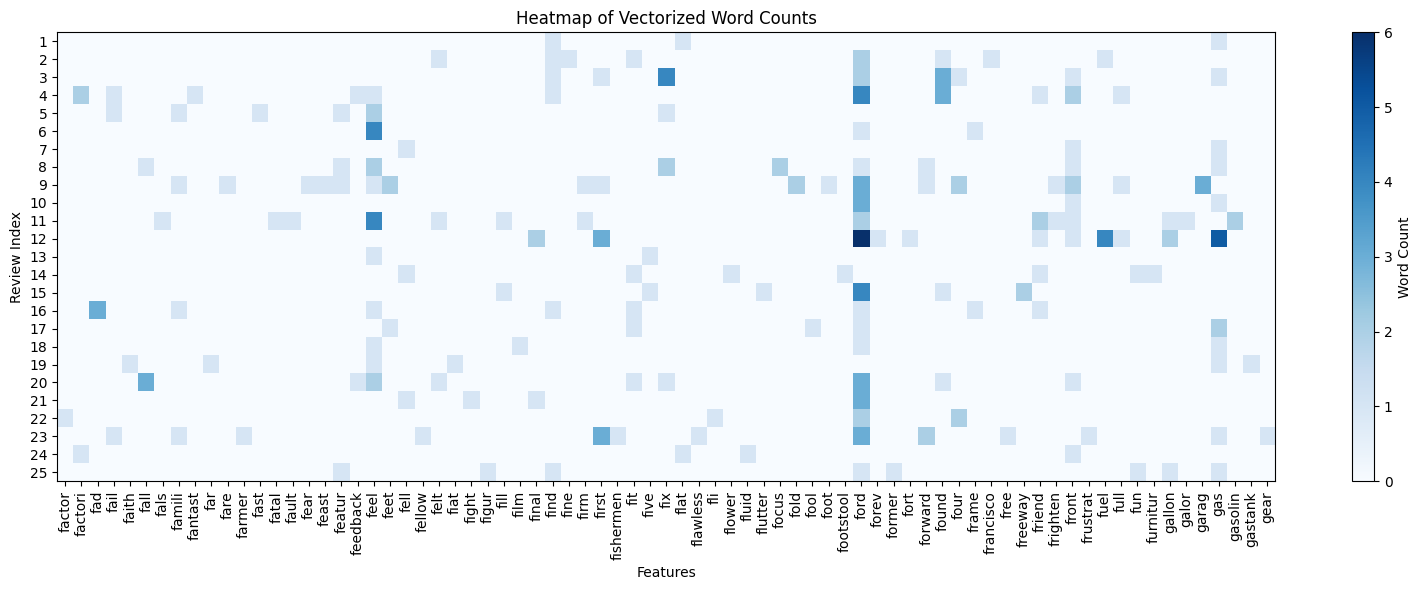

In [6]:
"""
Further demonstrate vectorisation.
"""

print(f"{end - start} features out of {len(feature_names)} extracted from first 25 reviews:")
print(short_feature_names)

plt.figure(figsize=(16, 6))
plt.imshow(dense_X, aspect='auto', cmap='Blues')
plt.xlabel("Features")
plt.ylabel("Review Index")
plt.title("Heatmap of Vectorized Word Counts")
plt.colorbar(label="Word Count")
plt.xticks(ticks=np.arange(len(short_feature_names)), labels=short_feature_names, rotation=90)
plt.yticks(ticks=np.arange(dense_X.shape[0]), labels=np.arange(1, dense_X.shape[0]+1))
plt.tight_layout()
plt.show()

#### Data Leakage

The model is made up of two main methods, train_model and test_model. Internally, train_model uses scikit-learn's CountVectorizer#fit_transform method to create a matrix where each row is a review, each column a distinct token and each cell the count of the respective token per review. train_model is called with train_df, where train_df is a stratified random selection of 80% of the original data set. train_model then trains a multinomial Naive Bayes model on these feature counts.

test_model tests the Naive Bayes model using the remaining 20% of the original data set by vectorising each review in test_df using the CountVectorizer#transform method. This differs from CountVectorizer#fit_transform in that, when generating the matrix of feature counts, new tokens in the test_df data set are ignored and predictions are made using only tokens first encountered in train_df. This is how this implementation handles features that appear only in the test data and not in the training data.

The downside to this behaviour is that we may implicitly ignore predictively important features in the test data set because the training data set did not have them, and so the model could not be trained using them. However, this behaviour is necessary to avoid data leakage between the training and test data sets.

Another possible form of data leakage can occur when features appear exclusively in one class of the training data and not the other. If those features are an artifact of the training sample rather than truly representative of the class, the model may overfit to those features. Therefore, when testing on data with a different feature distribution, the classifier's performance may degrade. This behaviour is mitigated by the inclusion of Laplace smoothing with a factor of 1, which reduces the impact of outliers in the distribution.

#### Training and Prediction

scikit-learn's MultinomialNB model is used to classify the car reviews by naive Bayes with a Laplace smoothing factor of 1. Multinomial Naive Bayes is a bag-of-words technique in which documents are described by word occurrences, and the relative position of the words in the document is ignored.

The model is trained with 80% of the original data set, train_df, and is tested with the remaining 20%, test_df.

In [7]:
"""
Train and test the Naive Bayes model.
"""

task_1_naive_bayes_model = NaiveBayesModel()
clf = task_1_naive_bayes_model.train_model(train_df)
task_1_y_test, task_1_predictions, task_1_score = task_1_naive_bayes_model.test_model(test_df)
print(f"Naive Bayes accuracy: {task_1_score}")

Naive Bayes accuracy: 0.7753623188405797


### Reporting

A combination of scikit-learn, matplotlib and seaborn are used to create a confusion matrix graphic displaying the performance of the classifier, which has an accuracy of approximately 77.54%.

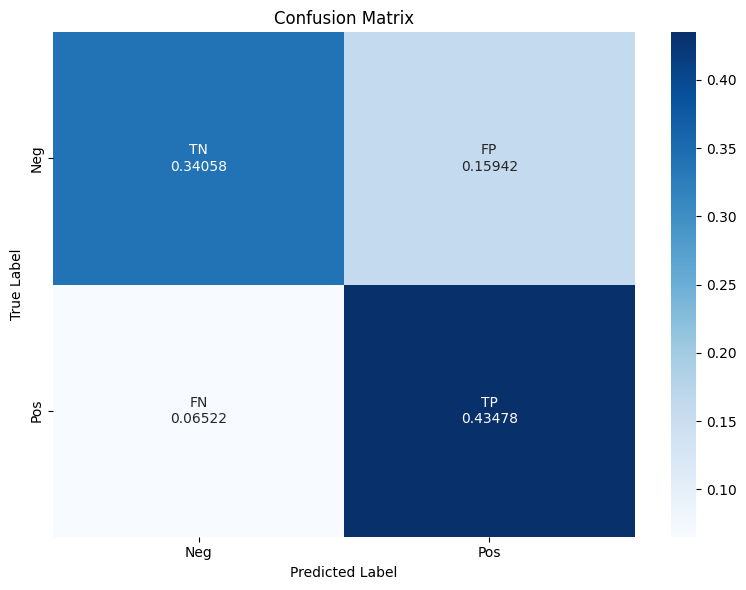

In [8]:
"""
Define the confusion matrix generating method and render the matrix.
"""

def plot_confusion_matrix(true_values, predictions):
    matrix = confusion_matrix(y_true=true_values, y_pred=predictions, normalize="all")

    cell_labels = np.array([["TN", "FP"],
                            ["FN", "TP"]])
    annot = np.empty_like(matrix, dtype=object)
    for i in range(2):
        for j in range(2):
            annot[i, j] = f"{cell_labels[i, j]}\n{matrix[i, j]:.5f}"
    fmt = ""
        
    classes = np.unique(true_values)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=annot, fmt=fmt, cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    # Extract the confusion matrix components:
    TN, FP = matrix[0, 0], matrix[0, 1]
    FN, TP = matrix[1, 0], matrix[1, 1]

    # Calculate precision, recall, and F1 score for the positive class
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score 

task_1_precision, task_1_recall, task_1_f1_score = plot_confusion_matrix(task_1_y_test, task_1_predictions)

## Task 2

## Approach

I have chosen to apply modifications to the original Naive Bayes implementation, with a particular focus on enhancing the pre-processing of the data used to train the model. The core hypothesis being investigated is, if more semantic information and a higher density of highly predictive features are used to train the model, then the model will be able to better differentiate between positive and negative car reviews. 

Capturing more semantic information is attempted by the introduction of lemmatisation and n-gram feature generation. Realising a higher density of highly predictive features is attempted by the introduction of term-frequency inverse-document-frequency vectorisation and feature selection.

These modifications will be detailed in the sections below.

### Defining a Cross Validation Baseline

The investigations below will use cross validation to assess the impact of the improvements individually and in aggregate. Therefore, a baseline accuracy using Task 1's Naive Bayes model must be established so that the marginal impact of the improvements can be evaluated.

In [9]:
"""
Define a cross validation accuracy baseline using the model created in Task 1.
"""

cross_val = task_1_naive_bayes_model.cross_validation(df)
model_cross_val_accuracy_reference = np.mean(cross_val)

results = []
results.append({
    "Model": "Naive Bayes",
    "Mean CV Accuracy": model_cross_val_accuracy_reference,
    "Marginal Accuracy Gain": 0
})
results_df = pd.DataFrame(results)
print(results_df)

         Model  Mean CV Accuracy  Marginal Accuracy Gain
0  Naive Bayes          0.785076                       0


## Pre-Processing Improvements

Several improvements have been made to the way the text is modelled prior to training. Machine learning and statistical models are trained on a vectorised interpretation of the corpus, and the quality of the vectorised input is correlated to the predictive power of the models (Russell and Norvig, 2022 p.876). A key focus of this work is not to strive for increased accuracy at any cost as compared to Task 1, rather it is to focus on improving the Naive Bayes model holistically and without overfitting to this limited training set.

Each proposed improvement will be tested against the model and pre-processing pipeline used in Task 1 to build an understanding of the marginal benefit each brings. Stratified 5-fold cross validation is used throughout Task 2 as an alternative to the 80/20 split mandated in Task 1, because it allows an unbiased evaluation and reduces variance (Bengio and Grandvalet, 2004). The folds are stratified to maintain the equal class balance of the original data set, which is important to prevent overfitting to an otherwise dominant class. 

A final evaluation will be made with the original 80/20 split for direct comparison with Task 1, but cross validation ensures a more realistic evaluation of the choices made in Task 2, and would ensure the resultant model generalises better to unseen data.

Review ingestion is unchanged as compared Task 1, with pandas used to read the car reviews CSV, and dataframes used extensively throughout for data manipulation.

### Lemmatisation

The tokenization algorithm is unchanged except for the replacement of stemming with lemmatisation. Both techniques reduce the inflected form of a token to a common root form, but lemmatisation reduces a token to an existing normalised form, whereas stemming only removes common suffixes (IBM, 2023). 

By integrating lemmatisation into the text encoding pipeline, similar tokens are consolidated into a single normalized form, resulting in a feature distribution that more accurately captures semantic information. In theory, lemmatisation unlocks a higher performance ceiling by enabling the model to capture nuanced differences in word usage (Siddhartha BS and YM, 2021). However, despite being theoretically superior, it may not lead to a real world improvement in model performance (Stanford, 2009).

The below code snippet partially replicates the tokenisation demonstration shown in Task 1. Observe how the output token set has increased in size from 16 to 18 after moving from stemming to tokenization. In this toy example, the increase in feature set size has reduced the predictive power of the otherwise stemmed tokens "purchas" and "famili". On the other hand, the model is aware of the morphological difference between the forms of, for example, "good" and "goodness", which could increase performance when applied across many training examples.

In [10]:
"""
Define the advanced ingestor that utilises lemmatisation.
Explicitly demonstrate lemmatisation.
"""

class AdvancedIngestor(Ingestor):
    """
    Advanced ingestor extends the base ingestor from Task 1.
    Uses lemmatisation instead of stemming.
    """
    def __init__(self):
        super().__init__()

    def tokenize_and_stem(self, text):
        # Remove accents
        stripped_text = self.strip_accents(text)
        
        # Tokenize text
        tokens = word_tokenize(stripped_text)
        
        # Include only alphanumeric tokens
        tokens = [token.lower() for token in tokens if token.isalnum()]
        
        # Remove stop words
        filtered_tokens = [word for word in tokens if word not in self.stop_words]
        
        # Lemmatise tokens
        return [wnl().lemmatize(token) for token in filtered_tokens]

advanced_ingestor = AdvancedIngestor()
df = advanced_ingestor.ingest_reviews()

example_review = "My Family familiés purchased it car after our 1988 Ford Taurus Station Wagon went out!!!  We thought  well  since the purchase that was and good goodness car  why dont we try this one"
print(f"Example review length {len(example_review.split())}")
print(example_review)
print()

result = set(ingestor.tokenize_and_stem(example_review))
print(f"Example review tokenised, stemmed and stop word filtered length {len(result)}")
print(result)
print()

result = set(advanced_ingestor.tokenize_and_stem(example_review))
print(f"Example review tokenised, lemmatised and stop word filtered length {len(result)}")
print(result)
print()

Example review length 33
My Family familiés purchased it car after our 1988 Ford Taurus Station Wagon went out!!!  We thought  well  since the purchase that was and good goodness car  why dont we try this one

Example review tokenised, stemmed and stop word filtered length 16
{'car', '1988', 'went', 'tri', 'ford', 'purchas', 'good', 'well', 'one', 'dont', 'thought', 'sinc', 'taurus', 'wagon', 'famili', 'station'}

Example review tokenised, lemmatised and stop word filtered length 18
{'car', 'since', '1988', 'purchase', 'went', 'ford', 'goodness', 'try', 'good', 'well', 'one', 'dont', 'purchased', 'family', 'taurus', 'wagon', 'thought', 'station'}



When the whole dataset is tokenised using lemmatisation instead of stemming, and vectorised using the same CountVectorizer used in Task 1, the feature set increases by 3900 features, or approximately 36%.

In [11]:
"""
Explicitly demonstrate the effect of lemmatisation on corpus vectorisation.
"""

vectorizer = CountVectorizer(tokenizer = ingestor.tokenize_and_stem)
X = vectorizer.fit_transform(df['Review'])
print(f"Number of processed features using stemming: {len(vectorizer.get_feature_names_out())}")

vectorizer = CountVectorizer(tokenizer = advanced_ingestor.tokenize_and_stem)
X = vectorizer.fit_transform(df['Review'])
print(f"Number of processed features using lemmatisation: {len(vectorizer.get_feature_names_out())}")

Number of processed features using stemming: 10942
Number of processed features using lemmatisation: 14832


The impact on model performance of the adoption of lemmatisation over stemming can be observed by testing both approaches using cross validation.

In [12]:
"""
Generate cross validation results for lemmatisation.
"""

class AdvancedNaiveBayesModel(NaiveBayesModel):
    """
    Extends the base Naive Bayes model to use the advanced ingestor.
    """
    def __init__(self):
        super().__init__(tokenize_and_stem = advanced_ingestor.tokenize_and_stem)

results = []        
model = AdvancedNaiveBayesModel()
cross_val = model.cross_validation(df)
accuracy = np.mean(cross_val)
results.append({
    "Model": "Naive Bayes with Lemmatisation",
    "Mean CV Accuracy": accuracy,
    "Marginal Accuracy Gain": accuracy - model_cross_val_accuracy_reference
})

results_df = pd.DataFrame(results)
print(results_df)

                            Model  Mean CV Accuracy  Marginal Accuracy Gain
0  Naive Bayes with Lemmatisation          0.780743               -0.004332


The replacement of stemming with lemmatisation results in a reduction in accuracy of 0.43%. However, consider that a 36% increase in the size of the feature set results in only a marginal reduction in accuracy for the cross validated model, and this result is aligned with the existing research (Senders, 2021 p.16). It is reasonable to hypothesise that a more accurate semantic representation, when combined with techniques to be discussed below such as feature selection, are worth the observed marginal cost on this data set.

### Feature Weighting

One common technique to improve model performance in text classification is to weight features not only by their frequency within individual documents, but also by their frequency across the whole corpus, and Term Frequency-Inverse Document Frequency (TF-IDF) is widely used for this purpose (Géron, 2022 p.472). Its key advantage is that it reduces the impact of common words and emphasises words that are more distinctive.

TF-IDF can be broken down into the following:
- Term Frequency (TF): measures how frequently a token appears in a document
- Inverse Document Frequency (IDF): measures how rare a token is across all documents

A token that appears frequently in a particular document but rarely in others is given a high weight, making it more predictive for that document's class. In contrast, common tokens receive lower weights, lessening their predictive power. Tuning feature weights in this way can result in a more discriminative and robust feature representation compared to simple counts.

In [13]:
"""
Generate cross validation results for TF-IDF vectorisation.
"""

class NaiveBayesModelTfidf(NaiveBayesModel):
    """
    Extends the base Naive Bayes model to use TF-IDF vectorisation.
    """
    def __init__(self):
        super().__init__()
        self.vectorizer = TfidfVectorizer(tokenizer = ingestor.tokenize_and_stem)

results = []
model = NaiveBayesModelTfidf()
cross_val = model.cross_validation(df)
accuracy = np.mean(cross_val)
results.append({
    "Model": "Naive Bayes with TF-IDF",
    "Mean CV Accuracy": accuracy,
    "Marginal Accuracy Gain": accuracy - model_cross_val_accuracy_reference
})

results_df = pd.DataFrame(results)
print(results_df)

                     Model  Mean CV Accuracy  Marginal Accuracy Gain
0  Naive Bayes with TF-IDF          0.781455               -0.003621


In theory, the use of TF-IDF produces a more informative feature set, leading to improved discrimination between classes. However, a small negative impact of -0.36% on model performance is observed.

### N-Gram Model

An issue with the Naive Bayes implementation in Task 1 is that the tokens are independent from one another. It is possible for a token in context to mean something different than without it, for example, the token "quarter" has a different meaning in "first quarter earnings" as compared to "fourth quarter touchdowns" (Russell and Norvig, 2022 p.877). An n-gram is a sequence of words like "first quarter earnings", and we can derive them from a data set to capture phrases in our model. 

Generating n-grams will result in a significant increase in the size of the feature set, but they enable contextualisation of otherwise ambiguous tokens that may be powerful predictors. However, it is computationally infeasible to produce n-grams up to the size of the corpus itself, so this task evaluates the effect on the model when using up to a 4-gram representation of the reviews. The n-grams are generated using scikit-learn's vectorizer ngram_range feature, and for the purposes of this task, all n-grams of length 1 to n, where n is less than 5, are calculated from the corpus.

In [14]:
"""
Generate cross validation results using various n-gram ranges.
"""

results = []
for i in [1,2,3,4]:
    ngram_range = (1, i)
    model = NaiveBayesModel()
    # Override the vectorizer's ngram_range parameter with the range to be tested
    model.vectorizer.ngram_range = ngram_range
    X = model.vectorizer.fit_transform(df['Review'])
    print(f"Number of features calculated when using n-gram range {ngram_range}: {len(model.vectorizer.get_feature_names_out())}")

    cross_val = model.cross_validation(df)
    accuracy = np.mean(cross_val)
    results.append({
        "Model": "Naive Bayes with N-Grams",
        "N-Gram Range": ngram_range,
        "Mean CV Accuracy": np.mean(cross_val),
        "Marginal Accuracy Gain": accuracy - model_cross_val_accuracy_reference
    })

results_df = pd.DataFrame(results)
print(results_df)

Number of features calculated when using n-gram range (1, 1): 10942
Number of features calculated when using n-gram range (1, 2): 201354
Number of features calculated when using n-gram range (1, 3): 496372
Number of features calculated when using n-gram range (1, 4): 805064
                      Model N-Gram Range  Mean CV Accuracy  \
0  Naive Bayes with N-Grams       (1, 1)          0.785076   
1  Naive Bayes with N-Grams       (1, 2)          0.793774   
2  Naive Bayes with N-Grams       (1, 3)          0.791613   
3  Naive Bayes with N-Grams       (1, 4)          0.783655   

   Marginal Accuracy Gain  
0                0.000000  
1                0.008698  
2                0.006537  
3               -0.001420  


The n-gram range (1, 2) produced the best result with an average accuracy improvement relative to the Task 1 implementation of 0.87%. It is interesting to note that, despite an approximately 20 times increase in feature set size between n-gram ranges (1, 1) and (1, 2), the model is still marginally more performant, indicating that some of the bigrams have significant predictive power.

### Feature Selection

As seen in the n-gram section above, even a relatively small data set like the car reviews used in this exercise can have a high dimensionality, with more than 800,000 features observed for n-grams ranging from 1 to 4 tokens. Feature selection has been proven to be effective in preparing high dimensionality data for various machine learning problems (Li et al., 2017), and it has been implemented to remove tokens that are rare, and therefore have a high variance in their predictive power (Russell and Norvig, 2022 p.876). A key issue in the sub-field of feature selection is the curse of dimensionality, which refers to phenomenon that data becomes more sparse in high dimensional space, which adversely affects algorithms designed for low dimensional inputs (Li et al., 2017). 

However, as can be observed in the Optimisation section below, Naive Bayes remains performant even when modelling high dimensionality data. Feature selection does yield a marginal increase in predictive power, and it also provides other non-functional benefits like improved training and inference time, and a more understandable, compact feature set.

Assessing the relative impact on performance of feature selection compared to the Task 1 model is difficult because the default feature set, which includes only unigrams, has just 10,492 features, approximately an order of magnitude lower than what the final model in Task 2 will be trained on. Therefore, the testing in the snippet below will use much smaller restrictions on maximum feature set size than will be seen in the remainder of Task 2, in order to better visualize the impact of feature selection on model performance. 

In [15]:
"""
Generate cross validation results for various maximum feature count configurations.
"""

results = []
for max_features in [100, 1000, 5000, None]:
    class NaiveBayesModelMaxFeatures(NaiveBayesModel):
        """
        Extends the base Naive Bayes model to use maximum feature constraints.
        """
        def __init__(self):
            super().__init__()
            self.vectorizer = CountVectorizer(tokenizer = ingestor.tokenize_and_stem, max_features = max_features)
    model = NaiveBayesModelMaxFeatures()

    X = model.vectorizer.fit_transform(df['Review'])
    print(f"Number of features calculated when max_features = {max_features}: {len(model.vectorizer.get_feature_names_out())}")

    cross_val = model.cross_validation(df)
    accuracy = np.mean(cross_val)
    results.append({
        "Model": "Naive Bayes with Feature Selection",
        "Max Features": max_features,
        "Mean CV Accuracy": accuracy,
        "Marginal Accuracy Gain": accuracy - model_cross_val_accuracy_reference
    })

print()
results_df = pd.DataFrame(results)
print(results_df)

Number of features calculated when max_features = 100: 100
Number of features calculated when max_features = 1000: 1000
Number of features calculated when max_features = 5000: 5000
Number of features calculated when max_features = None: 10942

                                Model  Max Features  Mean CV Accuracy  \
0  Naive Bayes with Feature Selection         100.0          0.692440   
1  Naive Bayes with Feature Selection        1000.0          0.774949   
2  Naive Bayes with Feature Selection        5000.0          0.781458   
3  Naive Bayes with Feature Selection           NaN          0.785076   

   Marginal Accuracy Gain  
0               -0.092636  
1               -0.010127  
2               -0.003618  
3                0.000000  


In this example with only unigrams, reducing the feature set worsened model performance, with the biggest drop in performance, -9.26%, occurring when only the most frequent 100 features were present. From this table it can be observed that retaining approximately the most frequent 1% of features is not enough to maintain model accuracy, but retaining approximately the most frequent 10% of features is.

### Laplace Smoothing

The Naive Bayes model only has a single tunable hyper-parameter, and that is alpha, the integer value to use during Laplace smoothing. Laplace smoothing is applied to the feature counts by the model, and it ensures features with zero counts have a non-zero contribution to the probability distribution (Chen and Goodman, 1999). Laplace smoothing also reduces the amplitude of high frequency occurrences; at the limit, high values of alpha will tend the distribution of word occurrences to a uniform distribution. In effect, Laplace smoothing acts as a regularisation technique for Naive Bayes models.

In [16]:
"""
Generate cross validation results for variations of Laplace smoothing coefficient.
"""

results = []
for i in range(4):
    alpha = i + 1
    model = NaiveBayesModel(alpha = alpha)

    cross_val = model.cross_validation(df)
    accuracy = np.mean(cross_val)
    results.append({
        "Model": "Naive Bayes with Custom Laplace Smoothing",
        "Alpha": alpha,
        "Mean CV Accuracy": np.mean(cross_val),
        "Marginal Accuracy Gain": accuracy - model_cross_val_accuracy_reference
    })

results_df = pd.DataFrame(results)
print(results_df)

                                       Model  Alpha  Mean CV Accuracy  \
0  Naive Bayes with Custom Laplace Smoothing      1          0.785076   
1  Naive Bayes with Custom Laplace Smoothing      2          0.781452   
2  Naive Bayes with Custom Laplace Smoothing      3          0.778559   
3  Naive Bayes with Custom Laplace Smoothing      4          0.778559   

   Marginal Accuracy Gain  
0                0.000000  
1               -0.003623  
2               -0.006517  
3               -0.006517  


Experimenting with alpha values greater than 1 only resulted in a negative impact on model performance.

### Optimisation

While the marginal benefit versus the original implementation in Task 1 has been established, the proposed improvements have the potential to perform better in conjunction than independently. To this end, 5-fold cross validation will be tested across the combination of proposed settings described so far, in an effort to find the configuration that maximises performance of the Naive Bayes model on this data set. Error bars are calculated as the standard deviation of the cross validation scores.

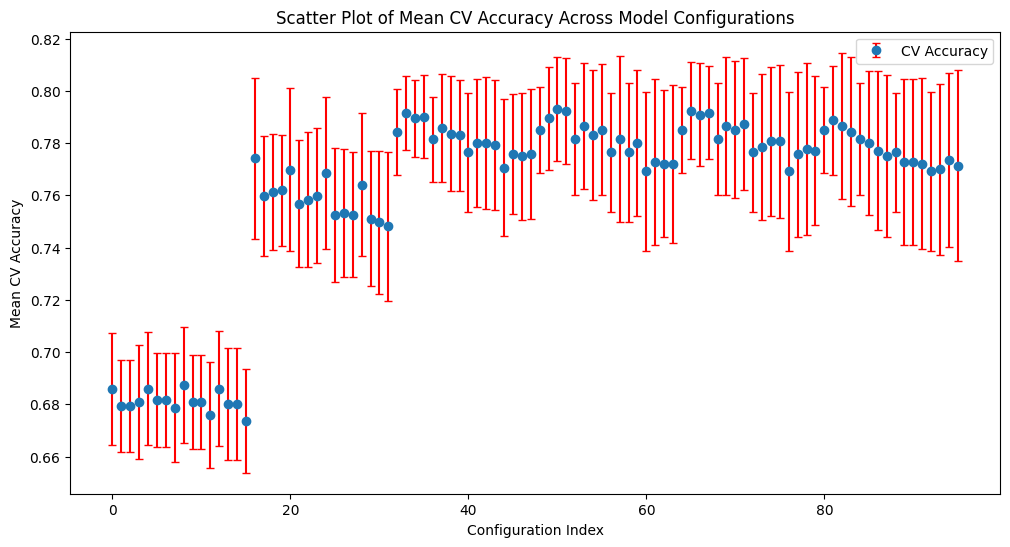

                   Model N-Gram Range  Alpha  Max Features  Mean CV Accuracy  \
0   Modified Naive Bayes       (1, 1)      1         100.0          0.685944   
1   Modified Naive Bayes       (1, 2)      1         100.0          0.679435   
2   Modified Naive Bayes       (1, 3)      1         100.0          0.679435   
3   Modified Naive Bayes       (1, 4)      1         100.0          0.680877   
4   Modified Naive Bayes       (1, 1)      2         100.0          0.685947   
5   Modified Naive Bayes       (1, 2)      2         100.0          0.681607   
6   Modified Naive Bayes       (1, 3)      2         100.0          0.681607   
7   Modified Naive Bayes       (1, 4)      2         100.0          0.678711   
8   Modified Naive Bayes       (1, 1)      3         100.0          0.687396   
9   Modified Naive Bayes       (1, 2)      3         100.0          0.680885   
10  Modified Naive Bayes       (1, 3)      3         100.0          0.680885   
11  Modified Naive Bayes       (1, 4)   

In [17]:
"""
Generate cross validation results for variations of all suggested improvements.
"""

def build_model(alpha, max_features, ngram_range):
    class NaiveBayesModelOptimised(NaiveBayesModel):
        """
        Extend the base Naive Bayes model with TF-IDF vectorizer, tokenization and configurable alpha, max_features and ngram_range parameters.
        """
        def __init__(self):
            super().__init__(alpha = alpha)
            self.vectorizer = TfidfVectorizer(tokenizer = advanced_ingestor.tokenize_and_stem, max_features = max_features, ngram_range = ngram_range)
    return NaiveBayesModelOptimised()

# Perform a grid search across investigated improvement configurations
optimised_results = []
for max_features in [100, 1000, 10000, 20000, 50000, None]:
    for alpha in [1,2,3,4]:
        for n_gram_upper_limit in [1,2,3,4]:
            ngram_range = (1, n_gram_upper_limit)
            model = build_model(alpha, max_features, ngram_range)
            cross_val = model.cross_validation(df)
            accuracy = np.mean(cross_val)
            accuracy_std = np.std(cross_val)
            optimised_results.append({
                "Model": "Modified Naive Bayes",
                "N-Gram Range": ngram_range,
                "Alpha": alpha,
                "Max Features": max_features,
                "Mean CV Accuracy": accuracy,
                "CV Accuracy Std": accuracy_std,
                "Marginal Accuracy Gain": accuracy - model_cross_val_accuracy_reference
            })
        
# Insert results into a dataframe for easier processing
optimised_results_df = pd.DataFrame(optimised_results)

# Plot mean accuracy with error bars
x = np.arange(len(optimised_results_df))
y = optimised_results_df["Mean CV Accuracy"]
yerr = optimised_results_df["CV Accuracy Std"]
plt.figure(figsize=(12, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, capthick=1, ecolor='red', label='CV Accuracy')
plt.xlabel("Configuration Index")
plt.ylabel("Mean CV Accuracy")
plt.title("Scatter Plot of Mean CV Accuracy Across Model Configurations")
plt.legend()
plt.show()

print(optimised_results_df)

best_index = optimised_results_df["Mean CV Accuracy"].idxmax()
best_row = optimised_results_df.loc[best_index]
cross_validation_final_score = best_row["Mean CV Accuracy"]
print()
print(f"Best score from cross validation grid search: {cross_validation_final_score}")

As a reminder, these results are generated using scikit-learns MultinomialNB model with a TF-IDF vectoriser and a custom tokenization pipeline, including lemmatisation. The settings resulting in the best model performance with an accuracy of 79.30% +/- 2% and a gain of 0.8% against the cross validated Naive Bayes model from Task 1 are:
- N-Grams: 1, 2 and 3-grams
- Alpha: 1
- Max Features: 20000

**For the remainder of this report, all results stated for "Modified Naive Bayes" are generated using these optimised settings.**

## Reporting

When training and testing on the 80/20 split data set from Task 1, Task 2's modified Naive Bayes model yielded an accuracy of 77.17% as opposed to Task 1's model which yielded an accuracy of 77.54%. The below "Evaluation Metrics Results" table and confusion matrix show only slight changes in precision, recall and F1 score, indicating the proposed improvements did not significantly change the model's tendency to produce false positives or false negatives. The slightly lower evaluation metrics can be explained by the slightly lower accuracy, because the data set in this exercise is balanced.

The central hypothesis driving the selection of the improvements investigated was that improving the density of semantic information and highly predictive features would improve model performance. Despite the improvements having sound theoretical grounding, the aggregate of their application to Naive Bayes resulted in a 0.36% decrease in accuracy when tested using the 80/20 split.

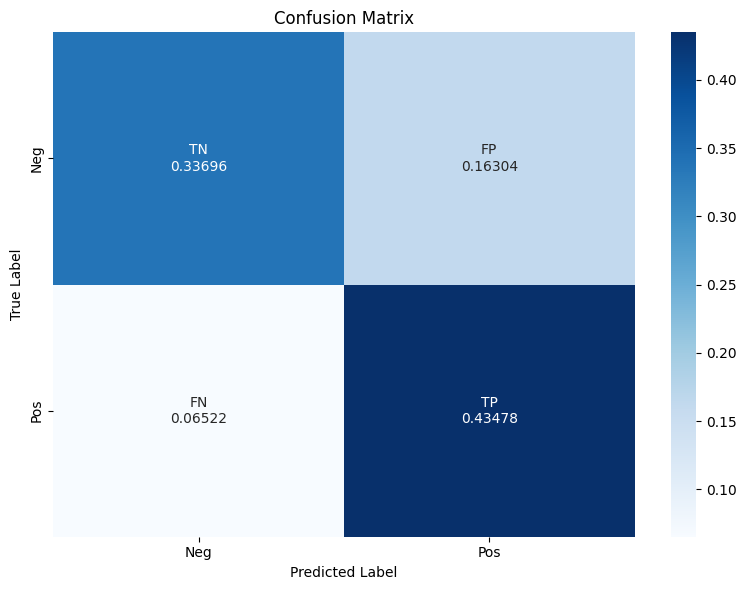

Evaluation Metrics Results
                  Model  Precision    Recall  F1 Score  Accuracy  \
0           Naive Bayes   0.731707  0.869565  0.794702  0.775362   
1  Modified Naive Bayes   0.727273  0.869565  0.792079  0.771739   

   Marginal Accuracy Gain  
0                0.000000  
1               -0.003623  

Final Comparison Results
                  Model  Mean Accuracy  Train/Test Split  \
0           Naive Bayes       0.775362       80/20 split   
1           Naive Bayes       0.785076  Cross validation   
2  Modified Naive Bayes       0.771739       80/20 split   
3  Modified Naive Bayes       0.793047  Cross validation   

   Marginal Accuracy Gain  
0                0.000000  
1                0.000000  
2               -0.003623  
3                0.007971  


In [18]:
"""
Generate model results for the optimal configuration of improvements using the 80/20 split for Task 1.
Display additional evaluation metrics, precision, recall and F1 score for comparison.
"""

class NaiveBayesModelFinal(NaiveBayesModel):
    """
    Extend the base Naive Bayes model with the best performing configuration of improvements.
    TF-IDF vectorizer, tokenization and alpha = 1, max_features = 20,000 and ngram_range = (1, 3).
    """
    def __init__(self):
        super().__init__(alpha = 1)
        self.vectorizer = TfidfVectorizer(tokenizer = advanced_ingestor.tokenize_and_stem, max_features = 20000, ngram_range = (1, 3))
model = NaiveBayesModelFinal()
model.train_model(train_df)
final_y_test, final_predictions, final_score = model.test_model(test_df)

final_precision, final_recall, final_f1_score = plot_confusion_matrix(final_y_test, final_predictions)

# Render final scores and evaluation metrics table
metrics_data = [
    {
        "Model": "Naive Bayes", 
        "Precision": task_1_precision, 
        "Recall": task_1_recall, 
        "F1 Score": task_1_f1_score, 
        "Accuracy": task_1_score, 
        "Marginal Accuracy Gain": 0
    },
    {
        "Model": "Modified Naive Bayes", 
        "Precision": final_precision, 
        "Recall": final_recall, 
        "F1 Score": final_f1_score, 
        "Accuracy": final_score,
        "Marginal Accuracy Gain": final_score - task_1_score
    }
]
df_metrics = pd.DataFrame(metrics_data)
print("Evaluation Metrics Results")
print(df_metrics)


"""
Generate a table to illustrate the difference between 80/20 split and cross validation on model performance.
"""

results = []
# Naive Bayes 80/20 split results
results.append({
    "Model": "Naive Bayes",
    "Mean Accuracy": task_1_score,
    "Train/Test Split": "80/20 split",
    "Marginal Accuracy Gain": 0
})

# Naive Bayes cross validation results
cross_val = task_1_naive_bayes_model.cross_validation(df)
accuracy = np.mean(cross_val)
results.append({
    "Model": "Naive Bayes",
    "Mean Accuracy": accuracy,
    "Train/Test Split": "Cross validation",
    "Marginal Accuracy Gain": 0
})

# Modified Naive Bayes 80/20 split results
results.append({
    "Model": "Modified Naive Bayes",
    "Mean Accuracy": final_score,
    "Train/Test Split": "80/20 split",
    "Marginal Accuracy Gain": final_score - task_1_score
})

# Modified Naive Bayes cross validation results
results.append({
    "Model": "Modified Naive Bayes",
    "Mean Accuracy": cross_validation_final_score,
    "Train/Test Split": "Cross validation",
    "Marginal Accuracy Gain": cross_validation_final_score - model_cross_val_accuracy_reference
})

results_df = pd.DataFrame(results)
print()
print("Final Comparison Results")
print(results_df)

Idiosyncracies of the 80/20 training set split are obscuring the benefit of the improvements. We can test for this by evaluating the accuracy of the Naive Bayes model from Task 1 using the 80/20 split and cross validation. We observe in the above "Final Comparison Results" table a 0.80% improvement in accuracy measured through cross validation, indicating that the 80% training set is less predictive of the remaining 20% test set than is to be expected on average. This at least partially explains why assessing the improvements via cross validation yields a greater benefit than when training and testing using the 80/20 split.

When compared in their most favourable scenario, that is, evaluated using cross validation with optimised settings, the pre-processing pipeline and vectorisation improvements discussed in Task 2 yield a 0.80% performance boost versus the model from Task 1. However, the error for this result is +/- 2%, which means that the measured improvement is smaller than the variability of the models performance, suggesting the improvement is not statistically significant.

This result suggests that Task 1's pre-processing pipeline, including unigrams and stemming, is as effective as the more sophisticated techniques explored in Task 2. One reason for this could be that the benefit of capturing semantic information has been overestimated, and that simple unigram counts are more predictive of a review's sentiment class in this data set. Another reason could be that the increased feature set size caused by lemmatisation replacing stemming has lessened the predictive power of key predictors in the data set, by converting them from a stem into one or more lemmas, thereby making the vectorised representation more sparse.

Given a broad range of techniques have been investigated and performance is effectively unchanged, this result also suggests that the multinomial Naive Bayes model has reached its performance ceiling for this data set, and that a more sophisticated model, such as a support vector machine, is needed to achieve better classification performance.

For future work, it would be interesting to investigate the relative performance of the pre-processing pipeline changes when applied to other classification models such as logistic regression. When compared to the work in Task 2, this comparison would offer insight into whether the pipeline changes are of equivalent efficacy across a range classification model types.

It is difficult to imagine a real world application of binary car review sentiment analysis that would materially benefit from a 0.80% improvement. It must also be considered that with a different data set or evaluation method, the advantage may disappear entirely. It is also unclear how the improvements would impact performance if the reviews were, for example, in another language, and this would also be an interesting candidate for future work. Considering the improvements require TF-IDF vectorisation as opposed to simple counts, a more complicated tokenization pipeline by virtue of lemmatisation, as well as a much larger initial feature set due to the introduction of n-grams, the additional computational and logical complexity, depending on the use case, is unlikely to be justified by the model performance.

# References

Chen, S.F. and Goodman, J., 1999. An empirical study of smoothing techniques for language modeling. Computer Speech and Language, 13(4), pp.359–394. Available from: https://www.sciencedirect.com/science/article/pii/S0885230899901286.

Bengio, Y. and Grandvalet, Y., 2004. No unbiased estimator of the variance of k-fold cross-validation. Journal of Machine Learning Research, 5.

Stanford, 2009. Stemming and lemmatization. Available from: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html [Accessed April 12, 2025].

Li, J., Cheng, K., Wang, S., Morstatter, F., Trevino, R.P., Tang, J., and Liu, H., 2017. Feature selection: a data perspective. ACM Computing Surveys, 50(6). Available from: http://dx.doi.org/10.1145/3136625.

Senders, Y., 2021. The impact of stemming and lemmatisation applied to word vector based models in sentiment analysis.

Siddhartha, B.S., Niveditha, N.M. and Manu, Y.M., 2021. An interpretation of lemmatization and stemming in natural language processing. Journal of University of Shanghai for Science and Technology, 22.

Géron, A., 2022. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O’Reilly.

Russell, S. and Norvig, P., 2022. Artificial Intelligence: A Modern Approach. Pearson Education Limited.

IBM, 2023. What are stemming and lemmatization? Available from: https://www.ibm.com/think/topics/stemming-lemmatization [Accessed April 12, 2025].